# Project course ML in business:  "Toxic comments detect system"

#### Stack:
- **ML:** NLP, XGBoost, TF-IDF, sklearn, pandas, numpy, matplotlib
- **API:** Flask, Flask_wtf
- **VM:** Docker
- **Data from kaggle:** Jigsaw Toxic comment competition
- **Task:** Create detect system (back-end and front-end servers) for predict different types of toxicity like threats, obscenity, insults, and identity-based hate. Binary classification and multi-targets.

## Train

Content:

    1. first a look at the data;
    2. split train data;
    3. save train and test data;
    4. prepare feature transforms;
    5. build pipeline;
    6. choose and save model;

### 1. First a look at the data

In [1]:
import pandas as pd
import numpy as np
import dill

# warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# preparing data
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import string

# working with text
from sklearn.feature_extraction.text import TfidfVectorizer

# normalizing data
from sklearn.preprocessing import StandardScaler

# imputer
from sklearn.impute import SimpleImputer

# pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

In [3]:
# models
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

# metrics
from sklearn.metrics import roc_auc_score, precision_recall_curve

In [4]:
df = pd.read_csv('csv/train_toxic.csv')
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [5]:
df.loc[(df['toxic'] == 1) | (df['severe_toxic'] == 1) | (df['obscene'] == 1)
       | (df['threat'] == 1) | (df['insult'] == 1) | (df['identity_hate'] == 1)]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0
...,...,...,...,...,...,...,...,...
159494,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1
159514,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0
159541,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0
159546,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0


About 10% of target data. Disbalanced classes.

In [6]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


### 2. Split train data

In [8]:
target = df.columns[2:].values
target

array(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'], dtype=object)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df[['comment_text']], df[target], random_state=42)

In [10]:
X_train.head(3)

,comment_text
75144,", I have added the newline sign back in, you ..."
154769,"Don't worry, I think I fixed it. But still loo..."
48346,"""\nWell it seems to me that you have a problem..."


In [11]:
y_train.head(3)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
75144,0,0,0,0,0,0
154769,0,0,0,0,0,0
48346,0,0,0,0,0,0


In [12]:
for i in y_train.columns :
    print("Percent of {0}s: ".format(i), round(100*y_train[i].mean(), 2), "%")

Percent of toxics:  9.59 %
Percent of severe_toxics:  0.99 %
Percent of obscenes:  5.27 %
Percent of threats:  0.31 %
Percent of insults:  4.9 %
Percent of identity_hates:  0.88 %


In [13]:
for i in y_test.columns :
    print("Percent of {0}s: ".format(i), round(100*y_test[i].mean(), 2), "%")

Percent of toxics:  9.56 %
Percent of severe_toxics:  1.02 %
Percent of obscenes:  5.37 %
Percent of threats:  0.26 %
Percent of insults:  5.04 %
Percent of identity_hates:  0.89 %


Let's make graphic for train data:

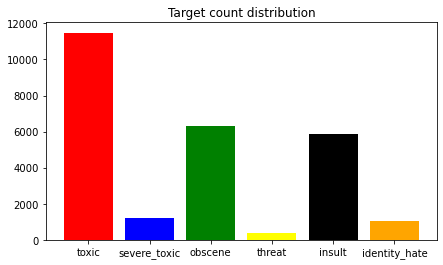

In [14]:
color = ['red','blue','green','yellow','black','orange']
plt.figure(figsize=(7, 4))
plt.bar(y_train.columns, y_train.sum(), color = color)
plt.title('Target count distribution')
plt.show()

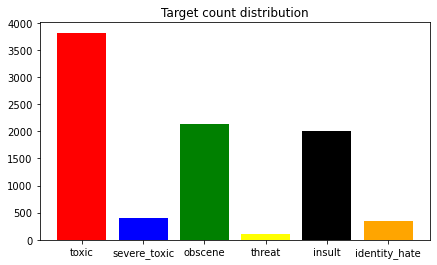

In [15]:
color = ['red','blue','green','yellow','black','orange']
plt.figure(figsize=(7, 4))
plt.bar(y_test.columns, y_test.sum(), color = color)
plt.title('Target count distribution')
plt.show()

We have got good shaffle train and test split. Let's save data:

### 3. Save train and test data

In [16]:
# save train
X_train.to_csv('csv/X_train.csv', index=None)
y_train.to_csv('csv/y_train.csv', index=None)

# save test
X_test.to_csv('csv/X_test.csv', index=None)
y_test.to_csv('csv/y_test.csv', index=None)

### 4. Prepare feature transforms

In [17]:
# select column
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    

# clean text with regular expressions
class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.pattern = ["i'm", "\r", "he's", "she's", "it's", "that's", "what's", "where's", "how's",\
                        "\'ll", "\'ve", "\'re", "\'d", "won't", "won't", "n't", "n'", "'bout",\
                        "'til", "[-()#\"\/\\\[\]@;:<>{}`+=~|.!?,]", "(\\W)", "\S*\d\S*\s*"]
        self.replace = ["i am", " ", "he is", "she is", "it is", "that is", "what is", "where is", "how is",\
                        " will", " have", " are", " would", "will not", "cannot", "not", "ng", "about",\
                        "until", " ", " ", ""]

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):  
        X = X.fillna('')
        X = X.str.lower()
        # loop all regex
        for pat, repl in zip(self.pattern, self.replace):
            X = X.str.replace(pat, repl)
        X = X.str.translate(str.maketrans('', '', string.punctuation))
        return X

Let's check the clean function:

### 5. Build pipeline

In [18]:
toxic = Pipeline([
    ('selector', ColumnSelector('comment_text')),
    ('cleaner', TextCleaner('comment_text'))
])

In [19]:
toxic.fit(X_train)

Pipeline(steps=[('selector', ColumnSelector(key='comment_text')),
                ('cleaner', TextCleaner(key='comment_text'))])

In [20]:
%%time
toxic.transform(X_test)

CPU times: user 4.25 s, sys: 144 ms, total: 4.4 s
Wall time: 4.45 s


119105    geez  are you forgetful   we have already disc...
131631    carioca rfa   thanks for your support on my re...
125326        birthday   no worries  it is what i do   e...
111256    pseudoscience category    i am assuming that t...
83590      and if such phrase exists  it would be provid...
                                ...                        
11066     citation listed is a valid source   deal with ...
141125                 fuck you               and your foot
158236    a photo of a magazine cover in a wikipedia art...
105667        danon says bluntly that he wants to take t...
155646        tell that to john carter and his amazing f...
Name: comment_text, Length: 39893, dtype: object

Good. Let's make final pipeline and choose the model:

### 6. Choose and save model

In [21]:
def evaluate_model(y_true, y_preds):
    # Precision Recall F-Score
    metrics_list = []
    ix_thresholds = []
    for i in range(y_true.shape[1]):
        precision, recall, thresholds = precision_recall_curve(y_true.iloc[:, i], y_preds[:, i])
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.argmax(fscore)
        metrics_list.append([thresholds, fscore, precision, recall])
        ix_thresholds.append(ix)
        print(f'Best Threshold for {y_test.columns[i]} = {thresholds[ix]}, \
        F-Score = {fscore[ix]:.3f}, Precision = {precision[ix]:.3f}, Recall = {recall[ix]:.3f}')
    
    # Mean F-Score
    fmean = []
    for i, m in zip(ix_thresholds, metrics_list):
        fmean.append(m[2][i])
    fscore_mean = np.mean(fmean)
    print(f'Mean F-Score = {fscore_mean}')
    
    # ROC AUC
    roc_auc = roc_auc_score(y_true, y_preds)
    print(f'ROC AUC = {roc_auc}')
    
    return fscore_mean, roc_auc

##### Logistic Regression:

Reupdate data:

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df[['comment_text']], df[target], random_state=42)

In [23]:
pipeline = Pipeline([
    ('selector', ColumnSelector('comment_text')),
    ('cleaner', TextCleaner('comment_text')),
    ('tfidf', TfidfVectorizer(stop_words='english', strip_accents='unicode', ngram_range=(1,2),\
                             token_pattern=r'\w{1,}', sublinear_tf=True, max_features=100000)),
    ('classifier', OneVsRestClassifier(LogisticRegression(C = 10,\
                    penalty='l2', solver = 'liblinear', max_iter=1000, random_state=42)))
])

In [24]:
%%time
pipeline.fit(X_train, y_train)

CPU times: user 1min 5s, sys: 1.3 s, total: 1min 6s
Wall time: 41.5 s


Pipeline(steps=[('selector', ColumnSelector(key='comment_text')),
                ('cleaner', TextCleaner(key='comment_text')),
                ('tfidf',
                 TfidfVectorizer(max_features=100000, ngram_range=(1, 2),
                                 stop_words='english', strip_accents='unicode',
                                 sublinear_tf=True, token_pattern='\\w{1,}')),
                ('classifier',
                 OneVsRestClassifier(estimator=LogisticRegression(C=10,
                                                                  max_iter=1000,
                                                                  random_state=42,
                                                                  solver='liblinear')))])

Let's save model:

In [25]:
%%time
with open('docker/app/models/logreg_pipeline.dill', 'wb') as f:
    dill.dump(pipeline, f)

CPU times: user 9.39 s, sys: 285 ms, total: 9.67 s
Wall time: 9.39 s


Reload test data:

In [26]:
X_test = pd.read_csv('csv/X_test.csv')
y_test = pd.read_csv('csv/y_test.csv')

In [27]:
%%time
preds = pipeline.predict_proba(X_test)
preds[0]

CPU times: user 6.95 s, sys: 77.4 ms, total: 7.02 s
Wall time: 7.05 s


array([0.04400561, 0.00314047, 0.00764626, 0.00052284, 0.016715  ,
       0.01668722])

In [28]:
fmean, roc_auc = evaluate_model(y_test, preds)

Best Threshold for toxic = 0.2748666660793717,         F-Score = 0.780, Precision = 0.792, Recall = 0.768
Best Threshold for severe_toxic = 0.11291179179782204,         F-Score = 0.474, Precision = 0.396, Recall = 0.589
Best Threshold for obscene = 0.2075214962069407,         F-Score = 0.814, Precision = 0.822, Recall = 0.806
Best Threshold for threat = 0.3584122050945679,         F-Score = 0.448, Precision = 0.617, Recall = 0.352
Best Threshold for insult = 0.1831494870977185,         F-Score = 0.711, Precision = 0.681, Recall = 0.744
Best Threshold for identity_hate = 0.09402841361070136,         F-Score = 0.454, Precision = 0.388, Recall = 0.546
Mean F-Score = 0.616041612116084
ROC AUC = 0.9766130962767745


In [29]:
# matrics table
models_result = pd.DataFrame(columns=['Approach', 'Mean F-Score', 'ROC AUC'])

In [30]:
models_result.loc[0] = ['LogisticRegression', fmean, roc_auc]
models_result

,Approach,Mean F-Score,ROC AUC
0,LogisticRegression,0.616042,0.976613


##### XGBoosting:

Reupdate data:

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df[['comment_text']], df[target], random_state=42)

In [32]:
pipeline = Pipeline([
    ('selector', ColumnSelector('comment_text')),
    ('cleaner', TextCleaner('comment_text')),
    ('tfidf', TfidfVectorizer(stop_words='english', strip_accents='unicode', ngram_range=(1,3),\
                             token_pattern=r'\w{1,}', sublinear_tf=True)),
    ('classifier', OneVsRestClassifier(xgb.XGBClassifier(objective='reg:squaredlogerror',\
                                                         use_label_encoder=False, random_state=42)))
])

In [33]:
%%time
pipeline.fit(X_train, y_train)

CPU times: user 1h 16min 56s, sys: 41 s, total: 1h 17min 37s
Wall time: 11min 45s


Pipeline(steps=[('selector', ColumnSelector(key='comment_text')),
                ('cleaner', TextCleaner(key='comment_text')),
                ('tfidf',
                 TfidfVectorizer(ngram_range=(1, 3), stop_words='english',
                                 strip_accents='unicode', sublinear_tf=True,
                                 token_pattern='\\w{1,}')),
                ('classifier',
                 OneVsRestClassifier(estimator=XGBClassifier(base_score=None,
                                                             booster=None,
                                                             colsample_bylevel=None,...
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                             

Reload test data:

In [34]:
X_test = pd.read_csv('csv/X_test.csv')
y_test = pd.read_csv('csv/y_test.csv')

In [35]:
%%time
preds = pipeline.predict_proba(X_test)
preds[0]

CPU times: user 27.5 s, sys: 7.92 s, total: 35.5 s
Wall time: 21.4 s


array([6.1595894e-02, 5.4449607e-05, 4.2534070e-03, 3.2858516e-04,
       5.5128741e-03, 8.6946628e-04], dtype=float32)

In [36]:
fmean, roc_auc = evaluate_model(y_test, preds)

Best Threshold for toxic = 0.31231170892715454,         F-Score = 0.735, Precision = 0.750, Recall = 0.720
Best Threshold for severe_toxic = 0.18469859659671783,         F-Score = 0.404, Precision = 0.324, Recall = 0.537
Best Threshold for obscene = 0.33159559965133667,         F-Score = 0.805, Precision = 0.804, Recall = 0.807
Best Threshold for threat = 0.3161265254020691,         F-Score = 0.390, Precision = 0.400, Recall = 0.381
Best Threshold for insult = 0.2822309732437134,         F-Score = 0.686, Precision = 0.638, Recall = 0.742
Best Threshold for identity_hate = 0.24755147099494934,         F-Score = 0.456, Precision = 0.438, Recall = 0.476
Mean F-Score = 0.5590562533546944
ROC AUC = 0.9303678135526031


In [37]:
models_result.loc[1] = ['XGBoost', fmean, roc_auc]
models_result

,Approach,Mean F-Score,ROC AUC
0,LogisticRegression,0.616042,0.976613
1,XGBoost,0.559056,0.930368


 Best score has got from LogisticRegression. We already have saved pipeline. Let's check it:

In [38]:
%%time
with open('docker/app/models/logreg_pipeline.dill', 'rb') as f:
    pipeline = dill.load(f)

CPU times: user 611 ms, sys: 446 ms, total: 1.06 s
Wall time: 1.21 s


In [39]:
pipeline

Pipeline(steps=[('selector', ColumnSelector(key='comment_text')),
                ('cleaner', TextCleaner(key='comment_text')),
                ('tfidf',
                 TfidfVectorizer(max_features=100000, ngram_range=(1, 2),
                                 stop_words='english', strip_accents='unicode',
                                 sublinear_tf=True, token_pattern='\\w{1,}')),
                ('classifier',
                 OneVsRestClassifier(estimator=LogisticRegression(C=10,
                                                                  max_iter=1000,
                                                                  random_state=42,
                                                                  solver='liblinear')))])